# Detectron2: Microcontroller Instance Segmentation
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 9.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=b5bf318e8d59f9e698241a9fa4d7a930ba37d80baa0d8180b336520d4b8dd900
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
     |████████████████████████████████| 6.4 MB 1.9 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 130 kB 21.3 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 144 kB 65.5 MB/s 
     |████████████████████████████████| 743 kB 60.5 MB/s 
     |████████████████████████████████| 722 kB 55.3 MB/s 
     |██

In [1]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 True


## Get data

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
!wget https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
!unzip microcontroller_segmentation_data.zip
!ls

--2021-08-13 11:09:02--  https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/master/microcontroller_segmentation_data.zip [following]
--2021-08-13 11:09:03--  https://raw.githubusercontent.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/master/microcontroller_segmentation_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17521676 (17M) [application/zip]
Saving to: ‘microcontroller_segmenta

In [4]:
!ls 'Microcontroller Segmentation'

labelme2coco.py  test  test.json  train  train.json


## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_microcontroller_dicts(directory):
    classes = ['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora']
    dataset_dicts = []
    for idx, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 600
        record["width"] = 800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("microcontroller_" + d, lambda d=d: get_microcontroller_dicts('Microcontroller Segmentation/' + d))
    MetadataCatalog.get("microcontroller_" + d).set(thing_classes=['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora'])
microcontroller_metadata = MetadataCatalog.get("microcontroller_train")

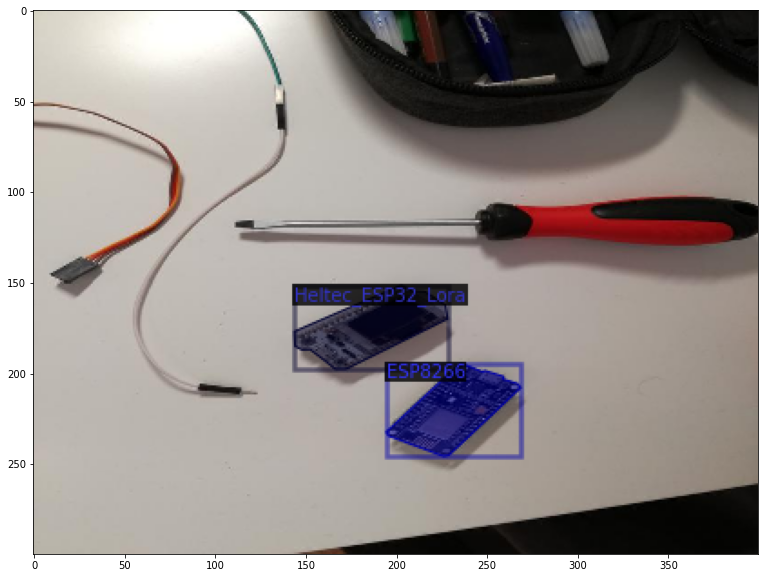

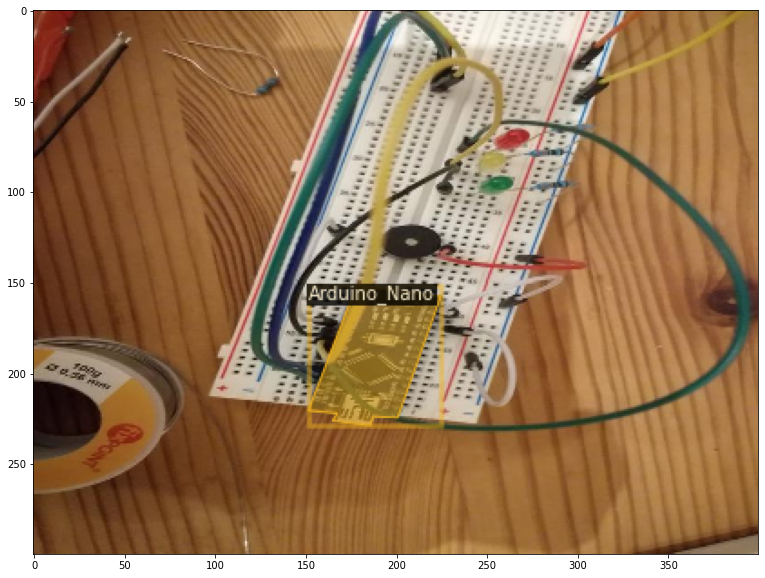

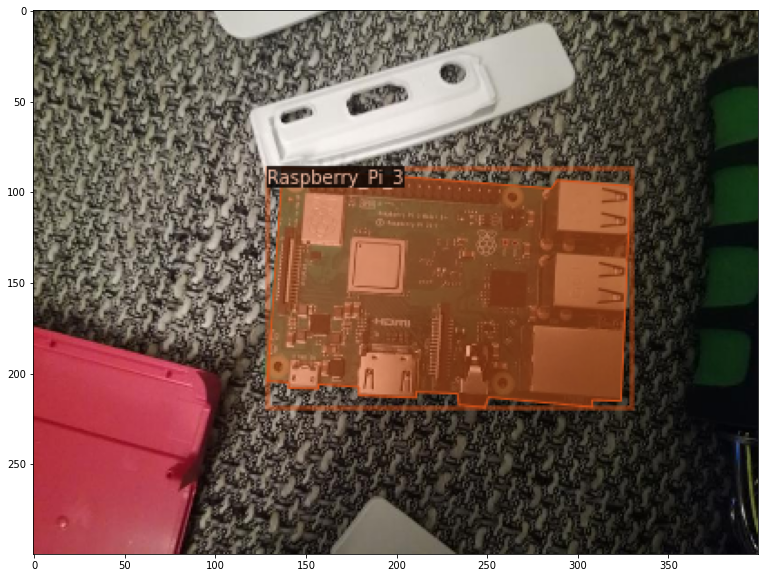

In [6]:
import random

dataset_dicts = get_microcontroller_dicts("Microcontroller Segmentation/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("microcontroller_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/13 11:09:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 67.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[08/13 11:09:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[08/13 11:09:33 d2.utils.events]:  eta: 0:07:24  iter: 19  total_loss: 2.51  loss_cls: 1.646  loss_box_reg: 0.1386  loss_mask: 0.6931  loss_rpn_cls: 0.008219  loss_rpn_loc: 0.00384  time: 0.4613  data_time: 0.0179  lr: 4.9953e-06  max_mem: 2336M
[08/13 11:09:42 d2.utils.events]:  eta: 0:07:17  iter: 39  total_loss: 2.354  loss_cls: 1.493  loss_box_reg: 0.1393  loss_mask: 0.6857  loss_rpn_cls: 0.006647  loss_rpn_loc: 0.00385  time: 0.4648  data_time: 0.0082  lr: 9.9902e-06  max_mem: 2336M
[08/13 11:09:51 d2.utils.events]:  eta: 0:07:07  iter: 59  total_loss: 2.002  loss_cls: 1.154  loss_box_reg: 0.1319  loss_mask: 0.6759  loss_rpn_cls: 0.006083  loss_rpn_loc: 0.004443  time: 0.4581  data_time: 0.0077  lr: 1.4985e-05  max_mem: 2336M
[08/13 11:10:01 d2.utils.events]:  eta: 0:07:05  iter: 79  total_loss: 1.64  loss_cls: 0.7963  loss_box_reg: 0.131  loss_mask: 0.6641  loss_rpn_cls: 0.007688  loss_rpn_loc: 0.004011  time: 0.4657  data_time: 0.0082  lr: 1.998e-05  max_mem: 2336M
[08/13 11:10:

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("microcontroller_test", )
predictor = DefaultPredictor(cfg)

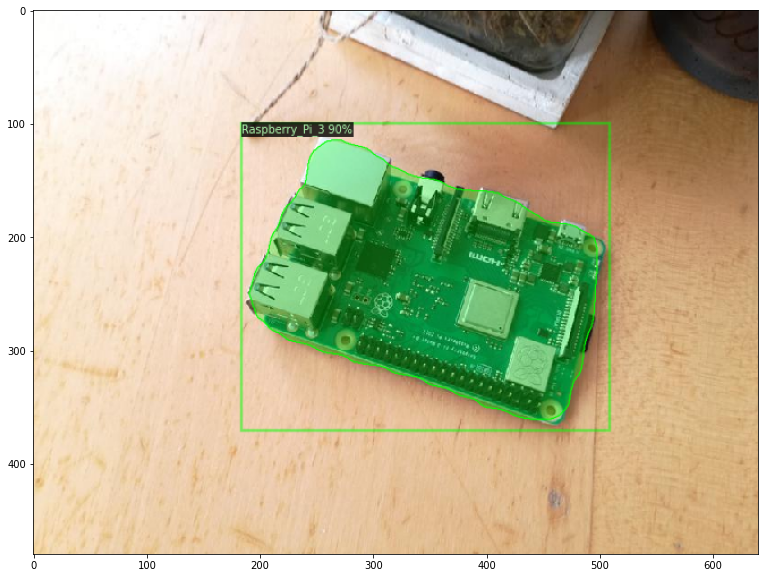

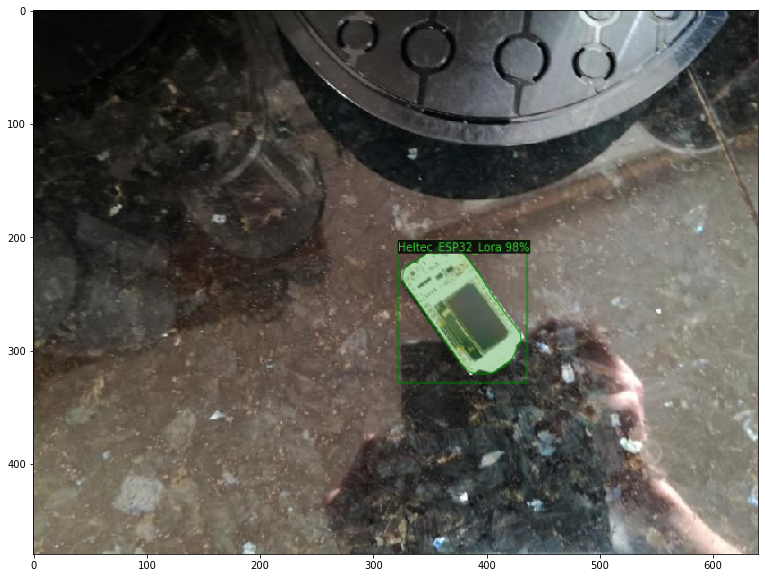

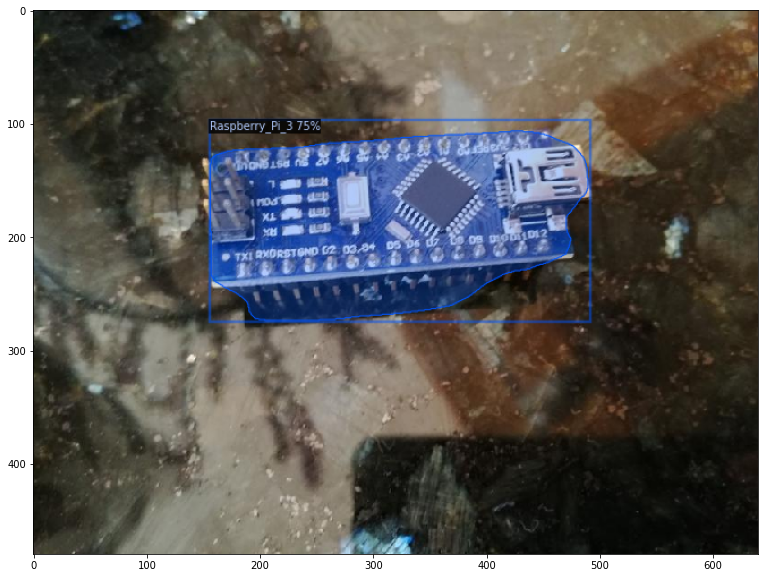

In [9]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_microcontroller_dicts('Microcontroller Segmentation/test')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()